## **FRAUD DETECTION USING MACHINE LEARNING**

#### **Project Overview**
**Goal**: Predict whether a transaction is fraudulent (isFraud = 1) or not (isFraud = 0) based on various features describing the transaction and the user’s identity.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, average_precision_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
# load the both train and test datasets
identity_train= pd.read_csv('../data/train_identity.csv')
transaction_train = pd.read_csv('../data/train_transaction.csv')

identity_test = pd.read_csv('../data/test_identity.csv')
transaction_test = pd.read_csv('../data/test_transaction.csv')

In [3]:
# Print dataset shapes and record counts
print("TRAIN DATASETS")
print("Identity train shape:", identity_train.shape)
print("Transaction train shape:", transaction_train.shape)

print("\nTEST DATASETS")
print("Identity test shape:", identity_test.shape)
print("Transaction test shape:", transaction_test.shape)



TRAIN DATASETS
Identity train shape: (144233, 41)
Transaction train shape: (590540, 394)

TEST DATASETS
Identity test shape: (141907, 41)
Transaction test shape: (506691, 393)


In [4]:
print("TRAIN DATA PREVIEW")
print("\nIdentity Train (first 5 records):")
identity_train.head()

print("\nTransaction Train (first 5 records):")
transaction_train.head()


TRAIN DATA PREVIEW

Identity Train (first 5 records):



Transaction Train (first 5 records):


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Key findings from the Datasets**

Identity Dataset
- Contains **144,233 rows** and **41 columns**.  
- Provides additional user identity and device-related information for a subset of transactions.  
- Major groups of features include:
  - `id_01–id_38`: Anonymized identity attributes (e.g., authentication methods, device usage).
  - `DeviceType`: Type of device used for the transaction (e.g., mobile or desktop).
  - `DeviceInfo`: Specific device or browser information.
- Categorical features are; `DeviceType`, `DeviceInfo`, `id_12 - id_38`
- Not all transactions have corresponding identity records, which explains the smaller number of rows in this dataset.


Transaction Dataset
- Contains **590,540 rows** and **394 columns**.  
- Includes transaction-level details such as:
  - `TransactionID`: Unique identifier for each transaction.
  - `isFraud`: Target variable (1 = fraudulent, 0 = genuine).
  - `TransactionDT`: Timedelta from a reference date (represents transaction time).
  - `TransactionAmt`: Transaction amount in USD.
  - `ProductCD`: Product code identifying the type of product for each transaction.
  - `card1–card6`: Payment card information, such as card type, card category, issue bank, country, etc.
  - `addr1`, `addr2`: Address information.
  - `dist1`, `dist2`: Distances between addresses or accounts.
  - `P_emaildomain`, `R_emaildomain`: Purchaser and recipient email domains.
  - `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc.
  - `D1-D15`: timedelta, such as days between previous transaction, etc.
  - `M1-M9`: match, such as names on card and address, etc. 
  - `V1–V339`: Anonymized features created from various transaction attributes. 
- Categorical features are; `ProductCD`, `card1 - card6`, `addr1`, `addr2`, `P_emaildomain`, `R_emaildomain`, `M1 - M9`.

In [5]:
#merge the datasets
train_df = transaction_train.merge(identity_train, how='left', on='TransactionID')
test_df = transaction_test.merge(identity_test, how='left', on='TransactionID')
print("\nThe merged Data (first 5 records):")
print(train_df.head())


The merged Data (first 5 records):
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0   

In [6]:
#check in the numerical columns
int_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
print(f"There are {len(int_columns)} numerical columns:")
print(int_columns.tolist())


There are 403 numerical columns:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94

In [7]:
#check in the categorical columns
cat_columns = train_df.select_dtypes(include=['object']).columns
print(f"There are {len(cat_columns)} categorical columns:")
print(cat_columns.tolist())


There are 31 categorical columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


**EDA**

In [8]:
#check for missing values
missing_counts = train_df.isna().sum()

percent_counts = (train_df.isna().mean()*100)

missing_values = pd.DataFrame({
    'num_missing': missing_counts,
    'percent_missing':percent_counts
}).sort_values(by='percent_missing', ascending=False)

top_missing = missing_values.head(20)
top_missing

,num_missing,percent_missing
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_27,585371,99.124699
id_23,585371,99.124699
id_22,585371,99.124699
dist2,552913,93.628374


**Missing Values for the top 20 columns**

- Some columns in the dataset have **extremely high missing rates** (over 99%):
  - `id_24` → 99.20% missing
  - `id_25` → 99.13% missing
  - `id_07`, `id_08` → 99.13% missing
  - `id_21` → 99.13% missing
  - `id_26`, `id_27`, `id_23`, `id_22` → 99.12% missing

- Other columns have **substantial missing values** (87–94%):
  - `dist2` → 93.63% missing
  - `D7` → 93.41% missing
  - `id_18` → 92.36% missing
  - `D12–D14` → ~89–89.5% missing
  - `id_03`, `id_04` → 88.77% missing
  - `D6` → 87.61% missing
  - `id_33` → 87.59% missing
  - `id_10` → 87.31% missing

- **Insights:**
  - Many `id_XX` columns are nearly empty, suggesting they may need to be **dropped**.
  - Several `D` and `dist` features have high missingness, indicating optional or rarely captured transaction metadata.
  - Missingness is **not uniform**, so careful treatment is needed to avoid bias during modeling.


2. <i>Fraud Distribution</i>

In [9]:
train_df['isFraud'].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

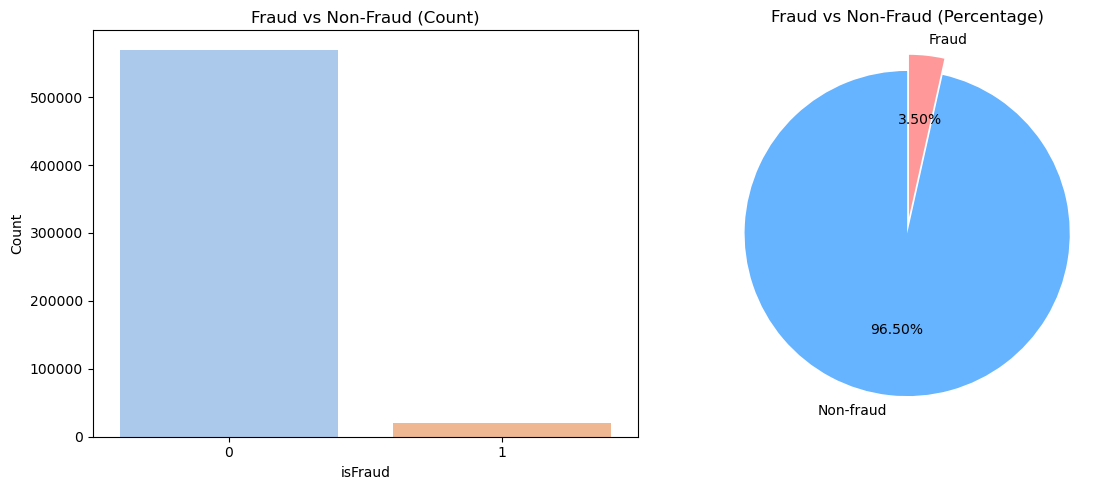

In [10]:
# Distribution of fraud 
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(data=train_df, x='isFraud', palette='pastel')
plt.title('Fraud vs Non-Fraud (Count)')
plt.xlabel('isFraud')
plt.ylabel('Count')

plt.subplot(1,2,2)
fraud_counts = train_df['isFraud'].value_counts()
plt.pie(fraud_counts,
        labels=['Non-fraud','Fraud'],
        autopct='%1.2f%%',
        startangle=90,
        colors=['#66b3ff', '#ff9999'],
        explode=(0, 0.1))
plt.title('Fraud vs Non-Fraud (Percentage)')
plt.tight_layout()
plt.show()

**Key insights**

- From the visualizations above, fraudulent transactions account for only about 3.5% of all transactions, while non-fraudulent transactions make up approximately 96.5%.

- This indicates a severe class imbalance in the dataset meaning the model could easily become biased toward predicting the majority (non-fraud) class. Therefore this imbalance will need to be handled carefully.

3. <i>Numerical Features</i>

In [11]:
#print in together the numerical colums
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

#exclude the fraud column
numerical_cols.remove('isFraud')

In [12]:
# get the correlation of the numerical columns with fraud
correlation = train_df[numerical_cols + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

In [13]:
top_positive_corr = correlation.head(20)  # top 20 positive correlations
print("Top positively correlated numerical features with isFraud:")
print(top_positive_corr)


Top positively correlated numerical features with isFraud:
isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
V44        0.260376
V86        0.251828
V87        0.251737
V170       0.249794
V147       0.242894
Name: isFraud, dtype: float64


In [14]:
top_negative_corr = correlation.tail(20)  # top 20  negative correlations
print("Top negatively correlated numerical features with isFraud:")
print(top_negative_corr)


Top negatively correlated numerical features with isFraud:
D4      -0.067216
V36     -0.069875
V11     -0.071950
D10     -0.072002
V10     -0.074658
V35     -0.077116
D15     -0.077519
D2      -0.083583
id_07   -0.084768
V70     -0.100900
V30     -0.103088
V69     -0.104521
V91     -0.105453
V29     -0.107852
V90     -0.110168
V49     -0.110920
V48     -0.115786
id_01   -0.120099
D7      -0.127199
D8      -0.142636
Name: isFraud, dtype: float64


**Numerical Features Correlation with `isFraud`**

Positive Correlations
- The majority of the **top positively correlated features** are `VXX` anonymized engineered features.
- **Strongest positive correlations**:
  - `V257` → 0.38
  - `V246` → 0.37
  - `V244` → 0.36
  - `V242` → 0.36
  - `V201` → 0.33
  - `V200` → 0.32
- Other notable features:
  - `V189`, `V188`, `V258` → 0.30–0.29
  - `V45`, `V158`, `V156`, `V149`, `V228` → 0.27–0.28
  - `V44`, `V86`, `V87`, `V170`, `V147` → 0.24–0.26

**Observations:**
- `VXX` features dominate, indicating they carry most of the predictive signal.
- Correlations are moderate (0.24–0.38).
- These features are **key candidates** for modeling.



Negative Correlations
- Top negatively correlated numerical features include `D` features, `VXX` engineered features, and some identity-related columns:
  - **Moderate negative correlations** (|corr| > 0.1):
    - `V70` → -0.10, `V30` → -0.10, `V69` → -0.10, `V91` → -0.11
    - `V29` → -0.11, `V90` → -0.11, `V49` → -0.11, `V48` → -0.12
    - `id_01` → -0.12, `D7` → -0.13, `D8` → -0.14
  - **Weaker negative correlations** (|corr| < 0.1):
    - `D4`, `V36`, `V11`, `D10`, `V10`, `V35`, `D15`, `D2`, `id_07` → -0.07 to -0.08

**Observations:**
- Negatively correlated features suggest **higher values are linked to lower likelihood of fraud**.
- Even moderate negative correlations may be useful when combined with positive predictors.
- Some `D` (duration/time-related) and `id_XX` features provide subtle signals of lower fraud probability.


In [15]:
# add in a threshhold of 0.2 to get the features related to fraud within the threshhold
threshhold= 0.2

selected_features = correlation[correlation.abs()> threshhold].index.tolist()
selected_features.remove('isFraud')

print("Numerical features with correlation > 0. 2 to isFraud:")
print(len(selected_features))
print(selected_features)


Numerical features with correlation > 0. 2 to isFraud:
32
['V257', 'V246', 'V244', 'V242', 'V201', 'V200', 'V189', 'V188', 'V258', 'V45', 'V158', 'V156', 'V149', 'V228', 'V44', 'V86', 'V87', 'V170', 'V147', 'V52', 'V157', 'V155', 'V230', 'V199', 'V148', 'V51', 'V171', 'V40', 'V243', 'V154', 'V190', 'V39']


In [16]:
#check in missing values for the selected features
missing = pd.DataFrame({
    'num_missing':train_df[selected_features].isna().sum(),
    'percent_missing':train_df[selected_features].isna().mean()*100
}).sort_values(by='percent_missing',ascending=False)

missing

,num_missing,percent_missing
V149,508595,86.123717
V158,508595,86.123717
V155,508595,86.123717
V157,508595,86.123717
V147,508595,86.123717
V154,508595,86.123717
V156,508595,86.123717
V148,508595,86.123717
V258,460110,77.913435
V243,460110,77.913435


In [17]:
# filter out features with upto 80% missing values
threshold_missing = 80  
clean_features = missing.loc[selected_features]
clean_features = clean_features[clean_features['percent_missing'] < threshold_missing].index.tolist()

print("Features to keep after filtering high missing values:")
print(clean_features)


Features to keep after filtering high missing values:
['V257', 'V246', 'V244', 'V242', 'V201', 'V200', 'V189', 'V188', 'V258', 'V45', 'V228', 'V44', 'V86', 'V87', 'V170', 'V52', 'V230', 'V199', 'V51', 'V171', 'V40', 'V243', 'V190', 'V39']


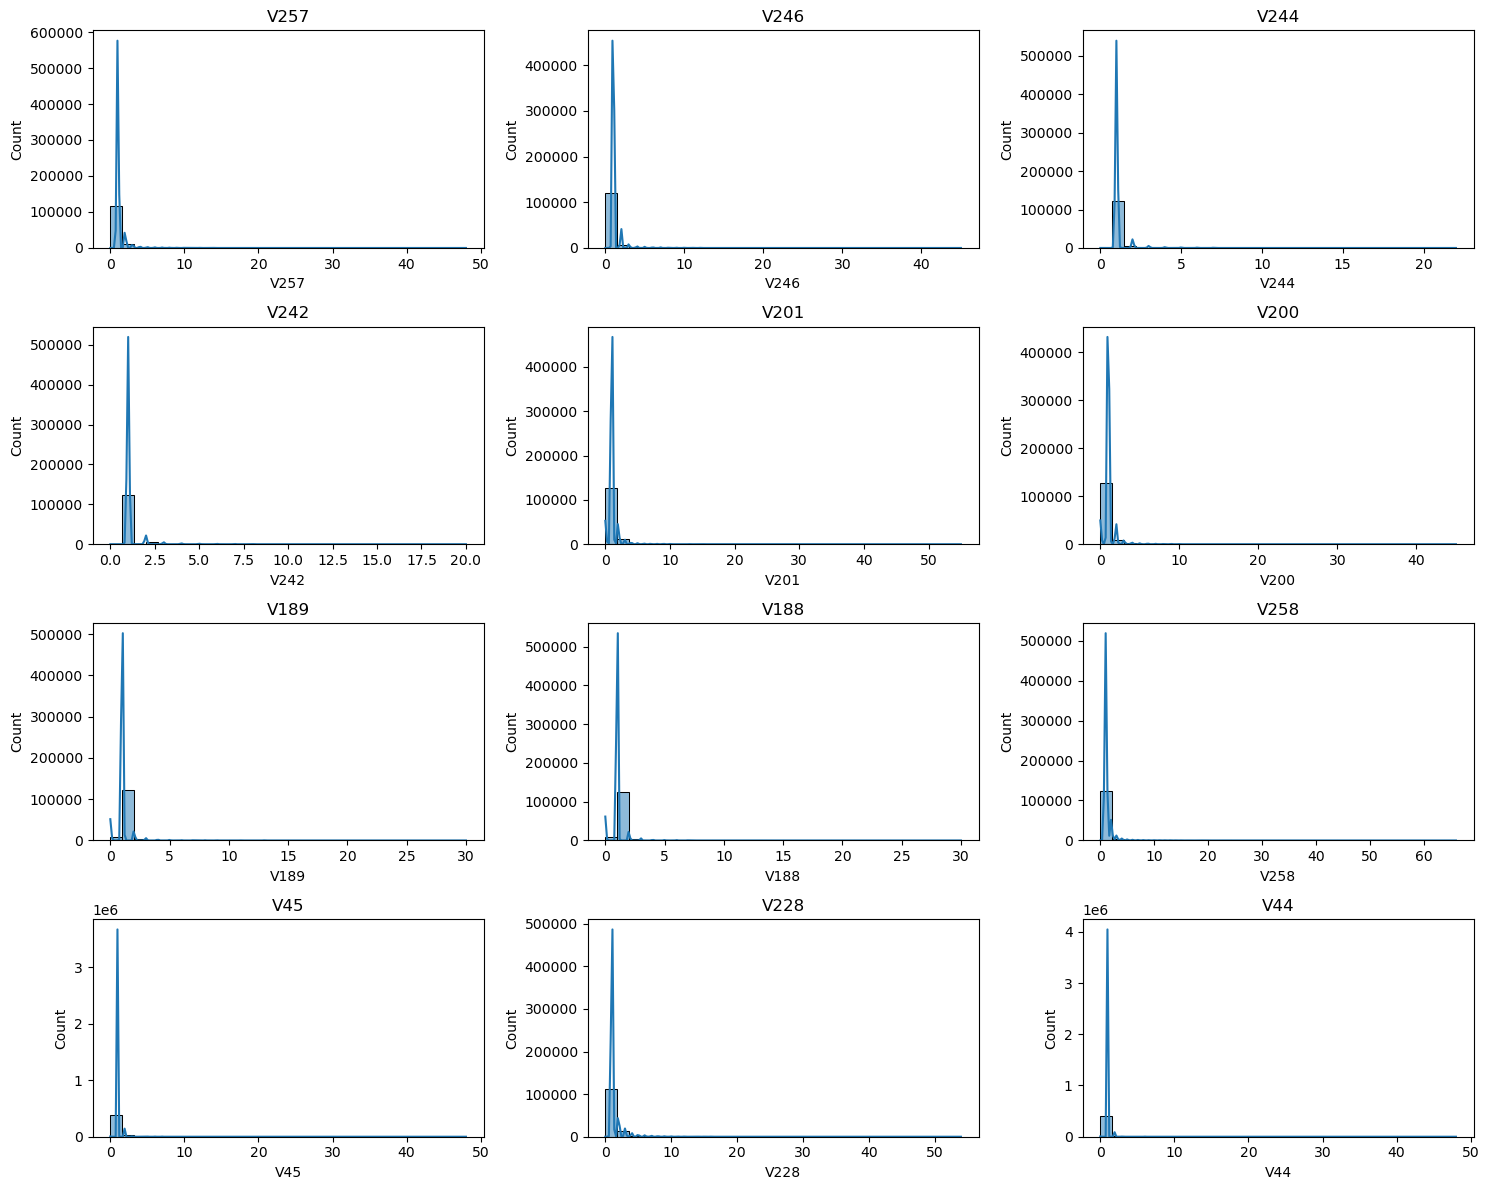

In [18]:
# Distribution of the numerical features 
plt.figure(figsize=(15,12))
for i, feature in enumerate(clean_features[:12]):  
    plt.subplot(4,3,i+1)
    sns.histplot(train_df[feature], bins=30, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


**key insights from the visual**
- Extreme Right Skewness: All features are highly right-skewed (positively skewed). This means the majority of the data is concentrated at the lowest values.

4. <i>Categorical Features</i>

In [19]:
cat_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29',
                'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
                'DeviceType', 'DeviceInfo']

# Number of missing values
missing_cat = train_df[cat_features].isna().sum()
missing_cat_percent = train_df[cat_features].isna().mean() * 100

missing_cat_summary = pd.DataFrame({
    'num_missing': missing_cat,
    'percent_missing': missing_cat_percent
}).sort_values(by='percent_missing', ascending=False)

print(missing_cat_summary)


               num_missing  percent_missing
id_27               585371        99.124699
id_23               585371        99.124699
id_33               517251        87.589494
id_30               512975        86.865411
id_34               512735        86.824771
DeviceInfo          471874        79.905510
id_16               461200        78.098012
R_emaildomain       453249        76.751617
id_31               450258        76.245132
DeviceType          449730        76.155722
id_29               449562        76.127273
id_28               449562        76.127273
id_38               449555        76.126088
id_37               449555        76.126088
id_36               449555        76.126088
id_35               449555        76.126088
id_15               449555        76.126088
id_12               446307        75.576083
M5                  350482        59.349409
M7                  346265        58.635317
M9                  346252        58.633115
M8                  346252      

**Missing Values in Categorical Features**
- Many categorical features have **extremely high missingness (>75%)**:

- Features with **moderate missingness (~28–60%)**:
  - M1–M9 (transaction metadata), P_emaildomain (~16%), M6 (~28%)

- Features with **very low or no missingness**:
  - card4 (~0.27%), card6 (~0.27%), ProductCD (0%)


**Observations**
- A large portion of categorical features (`id_27`, `id_23`, `DeviceInfo`, `DeviceType`, etc.) have **>75% missing values**, which makes them **less reliable for modeling**. 
- Transaction metadata (`M1–M9`) and email domains (`P_emaildomain`) are **partially complete**
- Stable categorical features (`card4`, `card6`, `ProductCD`) have almost no missing values and are safe for encoding.



In [20]:
# filter out features with upto 50% missing values
threshold_missing = 50  # percent
cat_features = missing_cat_summary[missing_cat_summary['percent_missing'] < threshold_missing].index.tolist()

print("Features to keep after filtering high missing values:")
print(cat_features)


Features to keep after filtering high missing values:
['M4', 'M3', 'M2', 'M1', 'M6', 'P_emaildomain', 'card4', 'card6', 'ProductCD']


Categorical Features After Missing Value Filtering

**Selected categorical features (less than 50% missing):**
`['M4', 'M3', 'M2', 'M1', 'M6', 'P_emaildomain', 'card4', 'card6', 'ProductCD']`

##### Why These Were Kept
- These features retain most of their data, ensuring consistency during modeling.
- They capture key behavioral or transactional patterns:
  - **ProductCD** → Type of product or transaction.
  - **card4, card6** → Card network and type (useful for risk profiling).
  - **P_emaildomain** → Customer email domain (potential fraud indicator).
  - **M1–M6** → Transaction match flags; can highlight identity consistency.
  
##### Features Dropped (>50% Missing)
- Features like `DeviceType`, `DeviceInfo`, and most `id_XX` fields were dropped due to excessive missingness, reducing noise.





In [21]:
cate_features = ['M4', 'M3', 'M2', 'M1', 'M6', 'P_emaildomain', 'card4', 'card6', 'ProductCD']
for col in cate_features:
    print(f"\nFeature: {col}")
    print(train_df.groupby(col)['isFraud'].mean().sort_values(ascending=False).head(10))



Feature: M4
M4
M2    0.113739
M0    0.036649
M1    0.027051
Name: isFraud, dtype: float64

Feature: M3
M3
F    0.030262
T    0.017054
Name: isFraud, dtype: float64

Feature: M2
M2
F    0.034852
T    0.018069
Name: isFraud, dtype: float64

Feature: M1
M1
T    0.019855
F    0.000000
Name: isFraud, dtype: float64

Feature: M6
M6
F    0.023686
T    0.017044
Name: isFraud, dtype: float64

Feature: P_emaildomain
P_emaildomain
protonmail.com    0.407895
mail.com          0.189624
outlook.es        0.130137
aim.com           0.126984
outlook.com       0.094584
hotmail.es        0.065574
live.com.mx       0.054740
hotmail.com       0.052950
gmail.com         0.043542
yahoo.fr          0.034965
Name: isFraud, dtype: float64

Feature: card4
card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64

Feature: card6
card6
credit             0.066785
debit              0.024263
charge card        0.000000
d

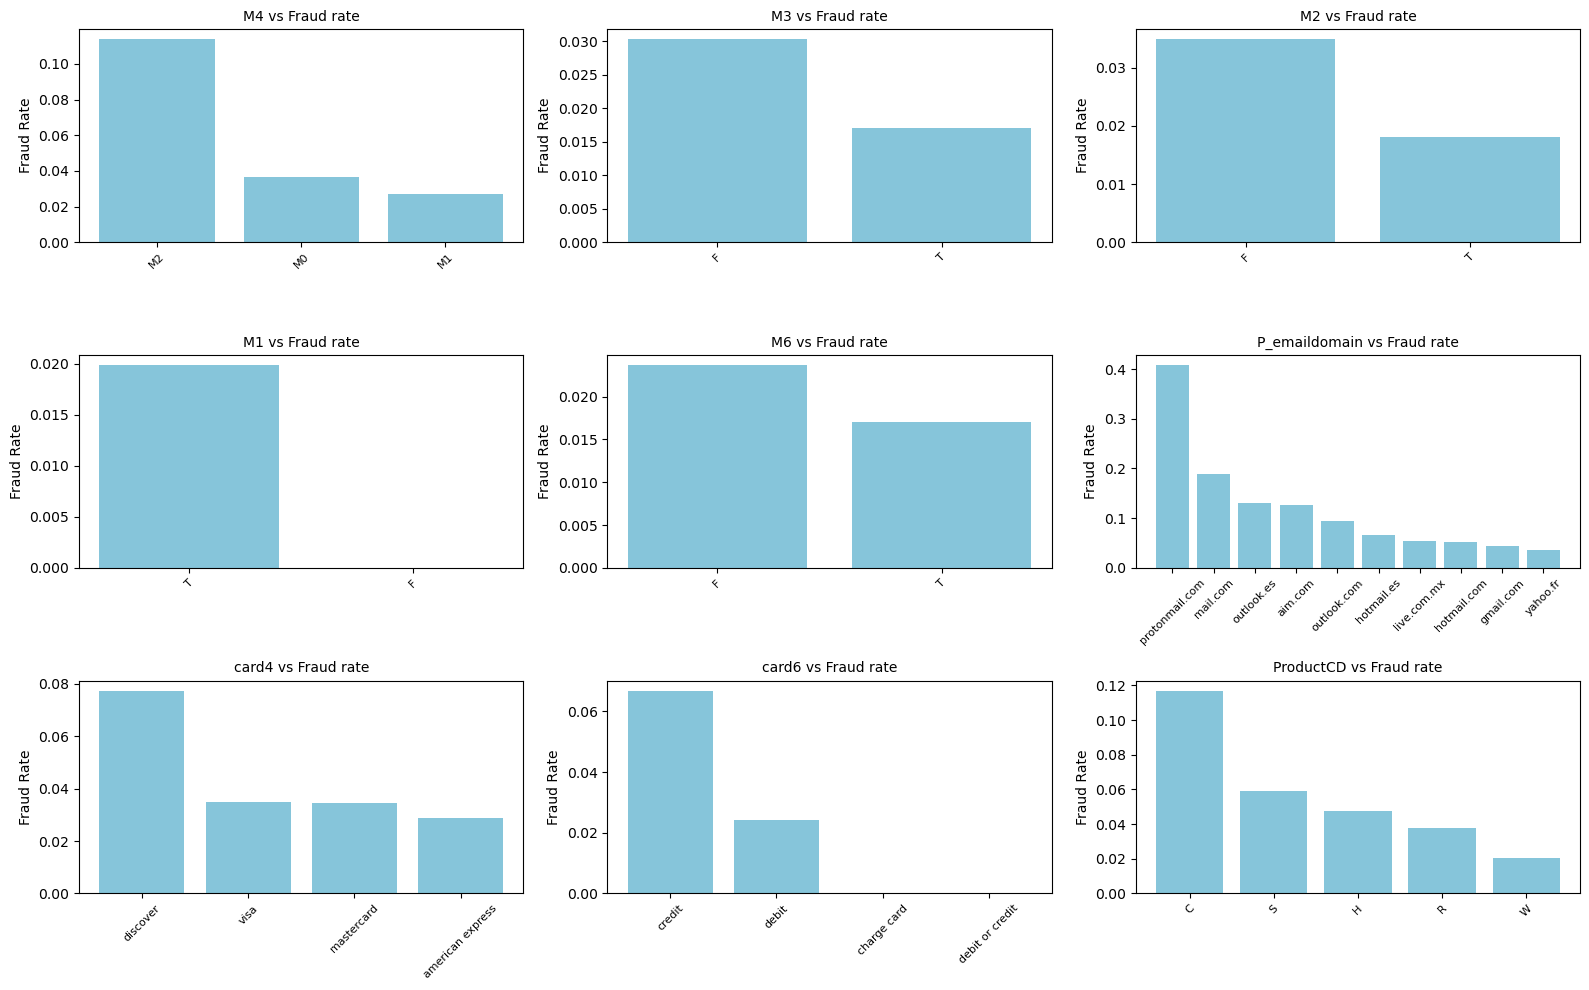

In [22]:
# Distribution of categorical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,10))
axes = axes.flatten()

for i, col in enumerate(cate_features):
    fraud_rate = train_df.groupby(col)['isFraud'].mean().sort_values(ascending=False).head(10)

    axes[i].bar(fraud_rate.index.astype(str), fraud_rate.values, color='#86c5da')
    axes[i].set_title(f"{col} vs Fraud rate", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].set_ylabel("Fraud Rate")

plt.tight_layout()
plt.show()

##### **Key Insights from Categorical Features vs Fraud Rate**

**1. ProductCD**
- Fraud rates differ greatly across product categories.  
- **Product “C”** shows the highest fraud rate (~11%), suggesting it is more prone to fraudulent transactions.  
- Products **“S”** and **“H”** show moderate fraud levels, while **“R”** and **“W”** appear relatively safer.  
- **Insight:** Certain product types may be inherently riskier possibly digital or high-value transactions.


**2. Card Type (`card4`, `card6`)**
- **card4:** Fraud is slightly higher for **Discover** (~7%) compared to **Visa** and **Mastercard** (~3–4%).  
- **card6:** **Credit cards** have higher fraud rates (~6%) than **debit cards** (~2%).  
- **Insight:** Card type plays a role in transaction risk credit-based transactions may be more targeted by fraudsters.

**3. Email Domains (`P_emaildomain`)**
- Fraud rates are higher for uncommon or privacy-focused email domains such as **protonmail.com**, **mail.com**, and **outlook.es** (10–40%).  
- Popular domains like **gmail.com**, **hotmail.com**, and **yahoo.com** have much lower fraud rates (<5%).  
- **Insight:** Fraudulent users often rely on less common or anonymous email services.

**4. Match Flags (`M1`–`M6`)**
- Match flag features (e.g., `M1`, `M2`, `M3`) show small but consistent relationships with fraud.  
- Typically, when the flag equals **True (T)**, the fraud rate is higher than when **False (F)**.  
- **Insight:** These features capture behavioral inconsistencies useful for detecting suspicious activity.

**5. Overall Summary**
- **Strongest indicators:** `ProductCD` and `P_emaildomain` show the clearest patterns.  
- **Moderate indicators:** `card4`, `card6`, and match flags (`M1–M6`) still contribute useful risk signals.  
- **Combined features:** Certain combinations (e.g., *Product C* + *Credit Card* + *ProtonMail*) likely signal higher risk.  



5. <i>Numerical Features (Counts and time delta)</i>

In [ ]:
"""
Compute the correlation between C (count) and D (time-delta) features and fraud label,
to identify the strongest predictors of fraudulent behavior.
"""
special_num_features = [f"C{i}" for i in range(1,15)] + [f"D{i}" for i in range(1,16)]
corr_special = train_df[special_num_features + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

print(corr_special)


isFraud    1.000000
C2         0.037229
C8         0.032139
C12        0.031905
C1         0.030570
C4         0.030382
C10        0.028396
C7         0.028160
C11        0.027484
C6         0.020909
C14        0.007921
C3        -0.006833
D14       -0.008663
C13       -0.011146
D12       -0.028864
C5        -0.030754
C9        -0.031703
D9        -0.044253
D11       -0.045094
D3        -0.046271
D6        -0.057236
D13       -0.059430
D5        -0.064638
D1        -0.067193
D4        -0.067216
D10       -0.072002
D15       -0.077519
D2        -0.083583
D7        -0.127199
D8        -0.142636
Name: isFraud, dtype: float64


**Key Insights**
- Most features have weak correlations with fraud.

- C-features (e.g., C2, C8, C12) show slight positive associations with fraud higher counts may indicate higher fraud likelihood.

- D-features (e.g., D7, D8, D2) show negative associations shorter times or smaller distances may relate to fraud.

- No single feature strongly predicts fraud, but combined patterns can help machine learning models detect fraudulent transactions.

**FEATURE ENGINEERING**

In [24]:
# Define numeric columns to keep
base_numeric = [
        'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
        'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2'
    ]

high_corr_numeric = [
        'V257', 'V246', 'V244', 'V242', 'V201', 'V200', 'V189', 'V188', 'V258',
        'V45', 'V228', 'V44', 'V86', 'V87', 'V170', 'V52', 'V230', 'V199', 'V51',
        'V171', 'V40', 'V243', 'V190', 'V39', 'C2', 'C8', 'C12', 'C1', 'C4',
        'C10', 'C7', 'C11', 'C6', 'C14', 'C3', 'D14', 'C13', 'D12', 'C5', 'C9',
        'D9', 'D11', 'D3', 'D6', 'D13', 'D5', 'D1', 'D4', 'D10', 'D15', 'D2',
        'D7', 'D8'
    ]

keep_numeric_cols = base_numeric + high_corr_numeric

# Identify numeric columns in both datasets
numeric_cols_train = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols_test = test_df.select_dtypes(include=['int64', 'float64']).columns

# Drop only unwanted numeric columns (keep categoricals intact)
drop_num_train = [col for col in numeric_cols_train if col not in keep_numeric_cols]
drop_num_test = [col for col in numeric_cols_test if col not in keep_numeric_cols]

train_df = train_df.drop(columns=drop_num_train, errors='ignore')
test_df = test_df.drop(columns=drop_num_test, errors='ignore')

# Fill missing numeric values
num_cols_to_fill = [col for col in keep_numeric_cols if col in train_df.columns and col != 'isFraud']
train_df[num_cols_to_fill] = train_df[num_cols_to_fill].fillna(-999)
test_df[num_cols_to_fill] = test_df[num_cols_to_fill].fillna(-999)

# Generate time-based features 
for df in [train_df, test_df]:
    if 'TransactionDT' in df.columns:
        df['Transaction_days'] = df['TransactionDT'] // (24 * 3600)
        df['Transaction_hours'] = (df['TransactionDT'] // 3600) % 24
        df['Transaction_weekday'] = df['Transaction_days'] % 7
        df.drop(columns=['TransactionDT'], inplace=True, errors='ignore')

# Drop TransactionID 
train_df = train_df.drop(columns=['TransactionID'], errors='ignore')
test_df = test_df.drop(columns=['TransactionID'], errors='ignore')


In [25]:
train_df.columns

Index(['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3',
       'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V39',
       'V40', 'V44', 'V45', 'V51', 'V52', 'V86', 'V87', 'V170', 'V171', 'V188',
       'V189', 'V190', 'V199', 'V200', 'V201', 'V228', 'V230', 'V242', 'V243',
       'V244', 'V246', 'V257', 'V258', 'id_12', 'id_15', 'id_16', 'id_23',
       'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'Transaction_days', 'Transaction_hours', 'Transaction_weekday'],
      dtype='object')

In [26]:
#categorical features 
cate_features = ['M4', 'M3', 'M2', 'M1', 'M6', 'P_emaildomain', 'card4', 'card6', 'ProductCD']

# Fill missing values with 'missing'
for col in cate_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna('missing')
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna('missing')

# Frequency Encoding for P_emaildomain 
if 'P_emaildomain' in train_df.columns:
    freq = train_df['P_emaildomain'].value_counts(normalize=True)
    train_df['P_emaildomain'] = train_df['P_emaildomain'].map(freq)
    test_df['P_emaildomain'] = test_df['P_emaildomain'].map(freq).fillna(0)

# Label Encoding for Other Categorical Columns ---
for col in [c for c in cate_features if c != 'P_emaildomain']:
    if col in train_df.columns:
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str)) + list(test_df[col].astype(str)))  # fit on both to avoid unseen classes
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))

# Drop Irrelevant Categorical Columns 
all_cat_features = [
        'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
        'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29',
        'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
        'DeviceType', 'DeviceInfo'
    ]

# columns to drop
drop_cat_columns = [col for col in all_cat_features if col not in cate_features]
train_df = train_df.drop(columns=[col for col in drop_cat_columns if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in drop_cat_columns if col in test_df.columns], errors='ignore')

missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    if col != 'isFraud':  # don't add target to test
        test_df[col] = -999
test_df = test_df[train_df.drop(columns=['isFraud']).columns]  # reorder


**Feature Summary**

The model uses a mix of **transactional, card, address, behavioral, and temporal features** to detect fraud.  
Transaction details (`TransactionAmt`, `ProductCD`, `TransactionDT`) capture spending behavior and timing.  
Card and address features (`card1–card6`, `addr1`, `addr2`, `dist1`, `dist2`) identify customer identity and location patterns.  
Count and time-delta features (`C`, `D` groups) describe frequency and timing of user activity.  
Anonymized behavioral variables (`V-series`) capture complex hidden patterns in customer behavior.  
Engineered temporal features (`Transaction_days`, `Transaction_hours`, `Transaction_weekday`) reveal unusual transaction times.  
Together, these features enable the model to learn **who, when, and how transactions occur**, improving its ability to flag suspicious or fraudulent activity.


**MODELLING**

In [27]:
#split the X and y
X = train_df.drop('isFraud', axis=1)
y = train_df['isFraud']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

1. XGBOOST MODEL

In [29]:
ratio = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.6,
    colsample_bytree=0.8,
    scale_pos_weight = ratio,
    random_state=42,
    n_jobs=-1,
    eval_metric='aucpr' 
)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"AUC-PR: {auc_pr:.4f}")

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113975
           1       0.21      0.82      0.34      4133

    accuracy                           0.89    118108
   macro avg       0.60      0.85      0.64    118108
weighted avg       0.97      0.89      0.92    118108

AUC-PR: 0.6034


In [30]:
#hyperparameter tuning
xgb_tuned = XGBClassifier(objective='binary:logistic', 
                          eval_metric='aucpr',
                          tree_method='hist',
                          random_state=42,
                          use_label_encoder=False)

#parameters
param_grid = {
    'n_estimators':[300,500,700],
    'max_depth':[3,5,7,9],
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,10],
    'min_child_wieght':[1,3,5,7],
    'gamma':[0,0.1,0.3,0.5],
    'reg_alpha':[0,0.01,0.1,1],
    'reg_lambda':[0.1,1,5,10],
    'scale_pos_weight':[1,5,10,20]
    }
  
#instantiate random search
rs = RandomizedSearchCV(
    estimator=xgb_tuned,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='average_precision',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#fit the model
rs.fit(X_train, y_train)

y_pred_xgbtuned = rs.predict(X_test)

print("Best parameters found: ", rs.best_params_)
print("Best score found: ", rs.best_score_)
best_xgb_model = rs.best_estimator_


y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("AUC-PR:", average_precision_score(y_test, y_pred_proba))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 20, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 700, 'min_child_wieght': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}
Best score found:  0.8007487442729504

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113975
           1       0.79      0.79      0.79      4133

    accuracy                           0.99    118108
   macro avg       0.89      0.89      0.89    118108
weighted avg       0.99      0.99      0.99    118108

AUC-PR: 0.8476249763425016


**Model insight**
- The tuned XGBoost model demonstrates strong predictive performance in detecting fraudulent transactions. It achieved an AUC-PR of 0.85 and maintained a high recall (0.79) for the fraud class, meaning it successfully identifies most fraudulent activities. Its precision of 0.79 indicates that the majority of transactions flagged as fraud are indeed fraudulent, minimizing false positives.

- From a business perspective, this model offers a balanced and reliable fraud detection system capable of reducing financial losses through accurate fraud identification while maintaining operational efficiency by avoiding unnecessary alerts on legitimate transactions.

2. LIGHTGBM MODEL

In [31]:
lgb_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)
# fit
lgb_model.fit(X_train,y_train,eval_metric='average_precision')

# Predict
y_pred_lgbm = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_lgbm))
print("AUC-PR:", average_precision_score(y_test, y_proba))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9357
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    113975
           1       0.41      0.84      0.55      4133

    accuracy                           0.95    118108
   macro avg       0.70      0.90      0.76    118108
weighted avg       0.97      0.95      0.96    118108

AUC-PR: 0.7830139408324893
ROC-AUC: 0.9635660812318126


In [32]:
# hyperparameter tuning
lgb_tuned = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=42
)

param_grid ={
    'num_leaves': [31,63,127],
    'max_depth': [6, 8, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [500, 800, 1000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1, 3, 5],
    'reg_lambda': [0, 1, 3, 5],
    'scale_pos_weight': [15, 20, 25] #handle class imbalanceness

}

random_search = RandomizedSearchCV(
    estimator=lgb_tuned,
    param_distributions=param_grid,
    n_iter=10,
    scoring='average_precision',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#fit
random_search.fit(X_train, y_train)

# Best model
best_lgbm = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)
print("Best score found:", random_search.best_score_)

# Evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("AUC-PR:", average_precision_score(y_test, y_proba_lgbm))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.707631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9357
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
Best parameters found: {'subsample': 0.9, 'scale_pos_weight': 25, 'reg_lambda': 1, 'reg_alpha': 5, 'num_leaves': 31, 'n_estimators': 1000, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score found: 0.7800398047839557

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    113975
           1       0.57      0.82      0.67      4133

    accuracy   

**Model Insight**
- The tuned LightGBM model shows robust performance in identifying fraudulent transactions, achieving an AUC-PR of 0.81 and a ROC-AUC of 0.97, which reflect strong discrimination between fraudulent and legitimate activities. The model maintained a high recall (0.82) for the fraud class, meaning it captures a large proportion of actual frauds, while the precision (0.57) suggests a moderate level of false positives.

3. CATBOOST MODEL

In [33]:
cat_model = CatBoostClassifier(
   iterations=1000,
   learning_rate=0.1,
   depth=8,
   eval_metric='AUC',
   random_state=42,
   verbose=200,
   class_weights=[1,20]

)

cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_cat))
print("AUC-PR:", average_precision_score(y_test, y_proba_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cat))

0:	total: 1.32s	remaining: 22m 1s
200:	total: 1m 55s	remaining: 7m 40s
400:	total: 3m 55s	remaining: 5m 51s
600:	total: 5m 55s	remaining: 3m 55s
800:	total: 7m 47s	remaining: 1m 56s
999:	total: 9m 36s	remaining: 0us
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.52      0.82      0.64      4133

    accuracy                           0.97    118108
   macro avg       0.76      0.90      0.81    118108
weighted avg       0.98      0.97      0.97    118108

AUC-PR: 0.7872254947376113
ROC-AUC: 0.9629389565960123


**Key Insights**
- **Accuracy:** 0.97 → Overall, the model correctly predicts 97% of all transactions.  
- **Fraud Detection (Class 1):**
  - **Recall (0.82):** The model successfully captures 82% of actual fraud cases — strong performance for imbalanced data.  
  - **Precision (0.52):** About half of the transactions flagged as fraud are truly fraudulent, showing some false positives.  
- **F1-score (Fraud = 0.64):** Indicates a fair trade-off between recall and precision for the minority class.  
- **ROC-AUC = 0.96:** Excellent discrimination between fraud and non-fraud.  
- **AUC-PR = 0.79:** Strong performance considering class imbalance shows effective handling of precision-recall trade-off.


In [35]:
  #---feature importance
feature_importance_x = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [36]:
feature_importance_x

,Feature,Importance
70,V258,0.364180
69,V257,0.130245
62,V201,0.033356
17,C5,0.029786
29,D3,0.020718
26,C14,0.018224
15,C3,0.017782
45,M4,0.016680
24,C12,0.014548
7,card6,0.011820


**Key Insights**
- The XGBoost model highlights V258 and V257 as the strongest indicators of fraud, suggesting these variables capture key behavioral or transaction patterns linked to suspicious activity.

- Other important features C5, C14, C3, and C12 show that transaction frequency and related account activity are major fraud signals. The D3 feature (time between transactions) also plays a key role, indicating that irregular or rapid transactions often correspond to fraudulent behavior.

- Overall, the model finds that fraud is best detected through a mix of behavioral, transactional, and temporal patterns, supported by card and device attributes.

In [37]:
     #---feature importance
feature_importance_l = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [38]:
feature_importance_l

,Feature,Importance
2,card1,2720
71,Transaction_days,2689
0,TransactionAmt,2379
8,addr1,1928
3,card2,1901
72,Transaction_hours,1172
12,P_emaildomain,1036
41,D15,899
25,C13,843
6,card5,787
